<a href="https://colab.research.google.com/github/juanetoboneto/Portafolio/blob/main/Series_de_Tiempo_con_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de Pronóstico para el S&P $500$.


En este proyecto, buscamos encontrar un modelo de pronóstico para los valores de mercado del índice Standard & Poor's $500$, que toma la capitalización bursátil de las $500$ empresas más grandes que cotizan sus acciones en la Bolsa de Nueva York o el NASDAQ.

Este tipo de datos encaja dentro de las llamadas "*Series de Tiempo*", y buscamos encontrar un modelo capaz de pronosticar los valores con los que cierra dicho índice en un periodo de aproximadamente $3$ meses.

Para ello, además de los módulos básicos necesarios como Pandas, NumPy y StatsModels, utilizaremos principalmente el paquete *Darts*. Además, extraeremos nuestros datos a través de una petición a la API de uso parcialmente gratuito de Alpha Vantage.

Comencemos por instalar e importar todas las herramientas necesarias.







In [ ]:
# Instalemos los paquetes no pre-establecidos:
!pip install darts

# Importemos todos los modulos básicos que vamos a utilizar:

import json
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from darts import TimeSeries

# Módulos necesarios para el pre-procesamiento
from statsmodels.tsa.stattools import adfuller
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller, BoxCox
from darts.dataprocessing.pipeline import Pipeline

from darts.models import NaiveDrift
from darts.utils.statistics import check_seasonality, plot_acf, plot_pacf
from darts.utils.utils import ModelMode, SeasonalityMode

# Importando el método para calcular MAPE
from darts.metrics import mape

# Modelos de pronóstico de Darts:
from darts.models import XGBModel

# Pruebas de Residuos:
from darts.utils.statistics import plot_residuals_analysis, stationarity_test_adf

# Paquetes de PyTorch para los modelos de Redes neuronales:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.regression import MeanAbsolutePercentageError

## 1.Extracción y Pre-procesamisento de los Datos:
Primero debemos extraer los datos de Apertura, Cierre, Mayor/Menor valor y el Volumen de Mercado, tambien conocidos como OHLCV del índice S&P $500$ en la bolsa de valores. Para ello utilizaremos la API de uso parcialmente gratuito `alphavantage` en formato `JSON` y procesarlo de tal manera que podamos trabajar con ellos.

Para esto debemos verificar que nuestra petición será respondida:


In [2]:
# Realicemos un solicitud de Datos de la API:
api_url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=SPY&outputsize=full&apikey=EMLUJFB0MBBTTW4O'
respuesta  = requests.get(api_url)

# Verifiquemos que obtuvimos los datos de la API y veamos cuales son sus "Llaves":
if respuesta.status_code == 200:
 archivo = respuesta.json()
 print(f'Llaves del archivo JSON: {archivo.keys()}')
else: print('Error al obtener los datos de la API')

# Transformemos nuestros datos en un DataFrame de Pandas:
sp = pd.DataFrame.from_dict(archivo['Time Series (Daily)'], orient='index')

# Realicemos el procesamiento de los datos:
sp = sp.rename(columns={'1. open':'apertura', '2. high':'mayor', '3. low':'menor', '4. close':'cierre', '5. volume':'volumen'})
sp = sp[::-1]
sp = sp.applymap(lambda x: pd.to_numeric(x, errors='coerce') if sp.columns.name != 'index' else x)
sp.index = pd.to_datetime(sp.index, errors='coerce', infer_datetime_format=True)

print('DataFrame de nuestra Serie de Tiempo:')
print(sp)

Llaves del archivo JSON: dict_keys(['Meta Data', 'Time Series (Daily)'])
DataFrame de nuestra Serie de Tiempo:
            apertura     mayor     menor    cierre   volumen
1999-11-01  136.5000  137.0000  135.5625  135.5625   4006500
1999-11-02  135.9687  137.2500  134.5937  134.5937   6516900
1999-11-03  136.0000  136.3750  135.1250  135.5000   7222300
1999-11-04  136.7500  137.3593  135.7656  136.5312   7907500
1999-11-05  138.6250  139.1093  136.7812  137.8750   7431500
...              ...       ...       ...       ...       ...
2023-11-21  453.1842  454.1310  451.9599  453.2700  49244639
2023-11-22  454.9800  456.3800  453.8895  455.0200  59446573
2023-11-24  455.0700  455.5000  454.7300  455.3000  29737375
2023-11-27  454.6500  455.4901  454.0799  454.4800  50505985
2023-11-28  454.0800  456.2700  453.5000  454.9300  61136740

[6058 rows x 5 columns]


Sobre los datos se puede decir que estos son los datos historicos del OHLCV de más de $20$ años con una frecuencia Diaria, más especificamente, datos desde el año $1999$ hasta la el día de la última petición hecha.

Para verificar que el tratamiento de nuestros datos fue el correcto, veamos una gráfica de los mismos:

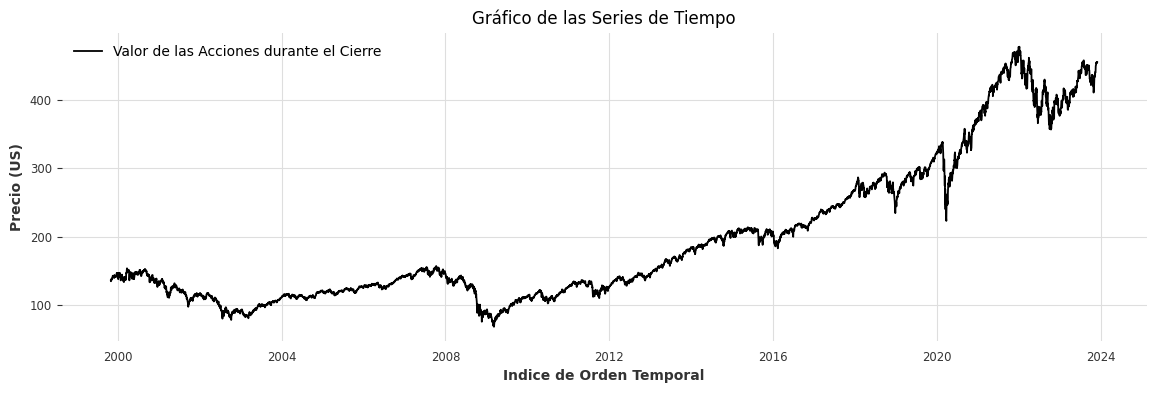

In [3]:
plt.figure(figsize=(14,4))

plt.plot(sp.index, sp['cierre'], label='Valor de las Acciones durante el Cierre')

plt.xlabel('Indice de Orden Temporal')
plt.ylabel('Precio (US)')

plt.title('Gráfico de las Series de Tiempo')
plt.legend()
plt.grid(True)
plt.show()

 ### 1.1. Arreglando nuestros datos:
 Para poder crear un modelo satisfactorio para pronosticar los valores futuros de nuestros datos tendremos que comparar las predicciones de dicho modelo con algunos datos.
 Para ello separaremos nuestros datos entre los de entrenamiento y validación, estos últimos corresponderan a aproximadamente $3$ meses o lo que es igual estos seran casi $93$ valores.

 Para ello primero debemos transformar dichos datos en un objeto "Serie de Tiempo" en `Darts`, despues rellenar los posibles valores faltantes y escalar dichos valores dentro de un rango $(0,1)$. Para ello crearemos un `Pipline` simple.

In [4]:
# Instanciemos nuestros datos como Series de Tiempo en Darts:
TS_SP = TimeSeries.from_dataframe(sp, freq='D')

# Construyamos una serie de instrucciones pipline, para rellenar y escalar las Series:
pipeline = Pipeline([MissingValuesFiller(), Scaler()])

# Procesemos las series de tiempo:
PTS_SP = pipeline.fit_transform(TS_SP)

# Por último separemos los datos de Entrenamiento y validación:
SP_ENT, SP_VAL = PTS_SP.split_before(pd.Timestamp('20230901'))

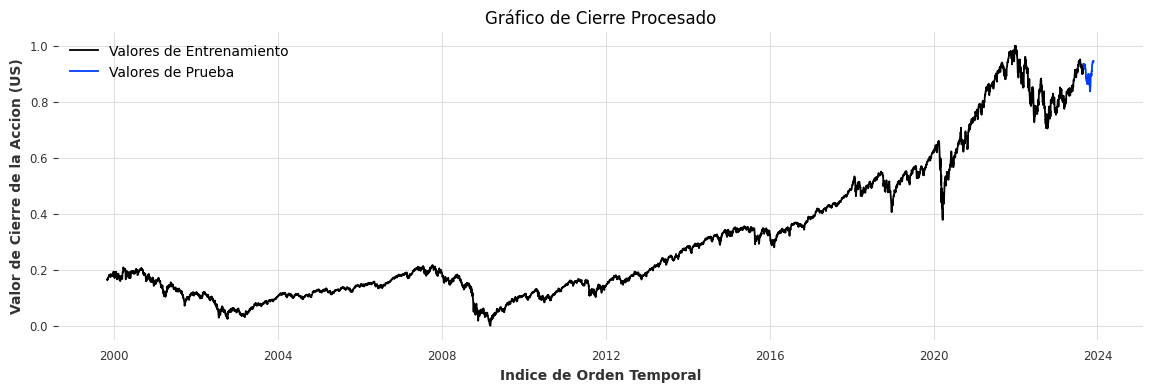

In [5]:
# Veamos como se comporta dichas transformaciones y la separación que hicimos gráficamente:
SP_ENT_GRA = SP_ENT.pd_dataframe()
SP_VAL_GRA = SP_VAL.pd_dataframe()

plt.figure(figsize=(14,4))

plt.plot(SP_ENT_GRA.index, SP_ENT_GRA['cierre'], label='Valores de Entrenamiento')
plt.plot(SP_VAL_GRA.index, SP_VAL_GRA['cierre'], label='Valores de Prueba')

plt.xlabel('Indice de Orden Temporal')
plt.ylabel('Valor de Cierre de la Accion (US)')

plt.title('Gráfico de Cierre Procesado')
plt.legend()
plt.grid(True)
plt.show()

#### 1.1.1. Serie de Tiempo Diferenciada.
Los valores de esta serie de tiempo no parecen poseer una tendencia o una estacionalidad clara, lo cual podría complicarnos la construcción de un modelo de pronóstico clásico. Por lo tanto, podemos utilizar la "*Diferenciación*" para transformar los datos de tal manera que podamos extraer información útil de ellos. Además de esto, eliminaremos los datos atípicos y realizaremos su preprocesamiento.

In [6]:
# Llamaremos a la serie de tiempo diferenciada como sigue:
D_TS_SP = PTS_SP.diff(n=1)

# Eliminemos los Outsiders:
D_TS_SP = D_TS_SP.pd_dataframe()

variables_a_filtrar = ['apertura', 'mayor', 'menor', 'cierre']

for variable in variables_a_filtrar:
    D_TS_SP[variable] = D_TS_SP[variable].apply(lambda x: x if (x >= -1.5 and x <= 1.5) else None)

D_TS_SP = TimeSeries.from_dataframe(D_TS_SP)

# Normalicemos y rellenemos los datos:
D_PTS_SP = pipeline.fit_transform(D_TS_SP)

In [7]:
# Separemos además esta serie diferenciada entre entrenamiento y validación:
D_SP_ENT, D_SP_VAL = D_PTS_SP.split_before(pd.Timestamp('20230901'))

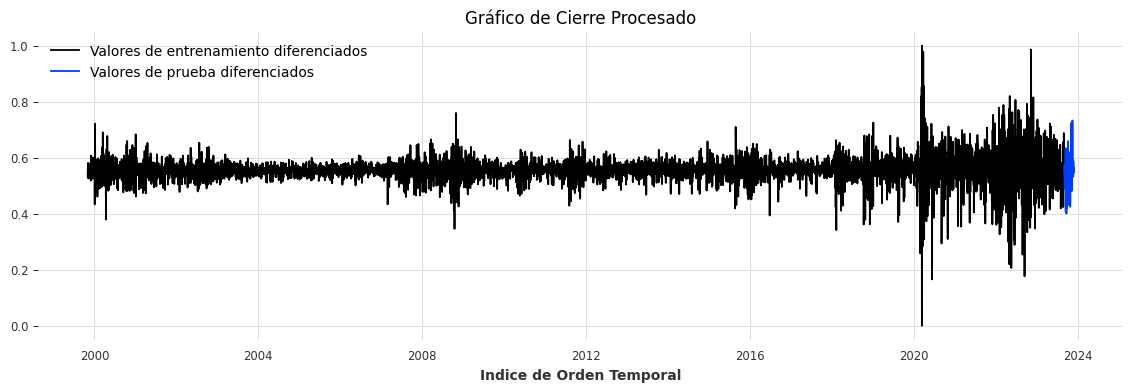

In [8]:
# Podremos tambien graficar dichas series diferenciadas:
D_PTS_SP_GRA = D_PTS_SP.pd_dataframe()
D_SP_ENT_GRA = D_SP_ENT.pd_dataframe()
D_SP_VAL_GRA = D_SP_VAL.pd_dataframe()

plt.figure(figsize=(14,4))

plt.plot(D_SP_ENT_GRA.index, D_SP_ENT_GRA['cierre'], label='Valores de entrenamiento diferenciados')
plt.plot(D_SP_VAL_GRA.index, D_SP_VAL_GRA['cierre'], label='Valores de prueba diferenciados')

plt.xlabel('Indice de Orden Temporal')

plt.title('Gráfico de Cierre Procesado')
plt.legend()
plt.grid(True)
plt.show()

Evidentemente, la Serie de Tiempo diferenciada no posee tendencia; aun asi podria resultar útil para hallar un modelo de pronóstico.

## 2. Estudio Preliminar.

Para poder hallar un modelo que pueda realizar un pronóstico satisfactorio de los datos debemos extraer información de las mismas; además de las propiedades estadísticas básicas que obtendremos mediante la propiedad `describe()`, para las series de tiempo tendremos que buscar otro tipo de propiedades.

In [9]:
SP_ENT_GRA.describe()

component,apertura,mayor,menor,cierre,volumen
count,8705.000000,8705.000000,8705.000000,8705.000000,8705.000000
mean,0.305063,0.303830,0.305777,0.305945,0.121702
std,0.247891,0.249959,0.247902,0.249006,0.103856
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.124638,0.121803,0.125538,0.124829,0.057117
50%,0.186891,0.184716,0.187414,0.186890,0.092089
75%,0.436392,0.433850,0.438136,0.437378,0.156330
max,1.000000,1.000000,1.000000,1.000000,1.000000


Dos propiedades fundamentales a estudiar en las series de tiempo son la tendencia y estacionalidad de los datos. No es la excepción para nuestro caso, por suerte `Darts` nos ofrece métodos para poder determinarlos.

En este caso utilizaremos además de buscar la estacionalidad realizaremos  la prueba **Dickey-Fuller** y las gráficas de la Función de Auto Correlación (**ACF**), esto normalmente se realiza en un rango de $25$ observaciones anteriores al momento "presente" (LAGS). Lastimosamente, este tipo de pruebas son de tipo *Univariado*.

In [10]:
# Utilicemos un ciclo 'for' para construir una función que busque la estacionalidad:
def buscador_de_estacionalidad(x, estacionalidad_encontrada=False):
 # Itera sobre el rango de valores de 'm'
 for m in range(2, 25):
    try:
        # Intenta buscar la estacionalidad para el valor de 'm'
        is_seasonal, period = check_seasonality(x, m=m)
        if is_seasonal :
            estacionalidad_encontrada=True
            print(f"Estacionalidad encontrada para m={m}")
    except Exception as e:
        # Captura excepciones (pueden ocurrir si 'm' no es adecuado para la serie de tiempo)
        pass

 # Verifica si se encontró al menos una estacionalidad
 if not estacionalidad_encontrada:
    print("No se encontró ninguna estacionalidad dentro del rango.")

In [11]:
# Apliquemos dicha función a nuestra serie:
buscador_de_estacionalidad(SP_ENT['cierre'])

No se encontró ninguna estacionalidad dentro del rango.


Para verificar la estacionalidad de las serie usaremos la **Prueba Dickey-Fuller**, esta es prueba estadística que generara un $p$-valor que nos permitira aceptar o negar la hipótesis nula. Más específicamente, si rechazamos la hipótesis nula nos inclinaremos a **aceptar la estacionalidad**, si no tendremos el caso opuesto de tal manera que creeremos muy improbable que exista la estacionalidad.

In [12]:
#Tomemos la variable sobre la que realizaremos la prueba:
Prueba_1 = SP_ENT['cierre'].pd_dataframe()
#Utilicemos el método de Darts para realizar la prueba:
adft_TS = adfuller(Prueba_1, autolag='AIC')

#Procesemos los resultados de dicha prueba:
prueba_TS = pd.DataFrame(
    {"Valores":[adft_TS[0], adft_TS[1], adft_TS[2], adft_TS[3], adft_TS[4]['1%'], adft_TS[4]['5%'], adft_TS[4]['10%']],
     "Métrica":['Prueba Estadística', 'p-Valor', 'No. de Lags usados', 'No. de Observaciones usadas', 'Valor Critico(1%)', 'Valor Critico(5%)', 'Valor Critico(10%)']}
    )

# Veamos los resultados de la pruba:
prueba_TS

,Valores,Métrica
0,1.285865,Prueba Estadística
1,0.996529,p-Valor
2,37.000000,No. de Lags usados
3,8667.000000,No. de Observaciones usadas
4,-3.431105,Valor Critico(1%)
5,-2.861874,Valor Critico(5%)
6,-2.566948,Valor Critico(10%)


Al tener un $p$-Valor tan alto es muy probable que, en efecto, esta serie no posea ninguna estacionalidad. Apesar de ello si parece poseer una tendencia de crecimiento positiva (al menos una lineal).

Tal vez, no podamos hallar una estacionalidad clara, sin embargo, podemos intentar obtener información apartir de una gráfica de *Autocorrelación*, aunque no tengamos una estacionalidad definida:

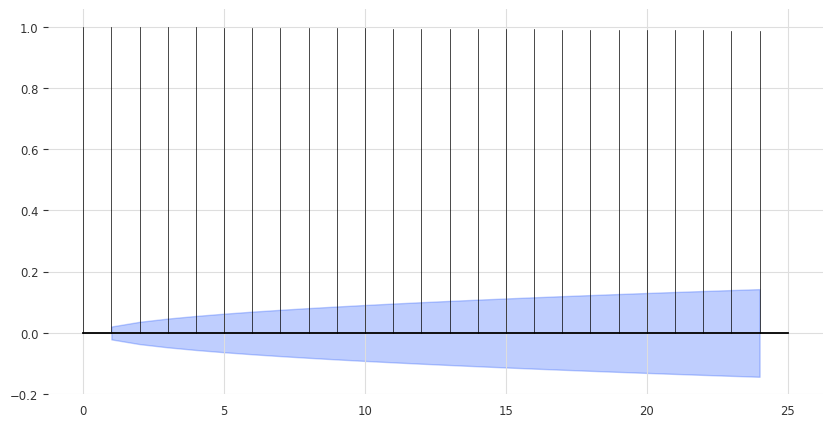

In [13]:
plot_acf(SP_ENT['cierre'])

Debido a que en la gráfica anterior no muestra que la correlación decaiga hacia $0$ no parece tener sentido aplicar ni un modelo AR ni uno MA (consecuentemente tampoco un ARIMA).

Apesar de ello, podemos intentar obtener más información apartir de la gráfica de la función de Auto Correlación Parcial **PACF**.

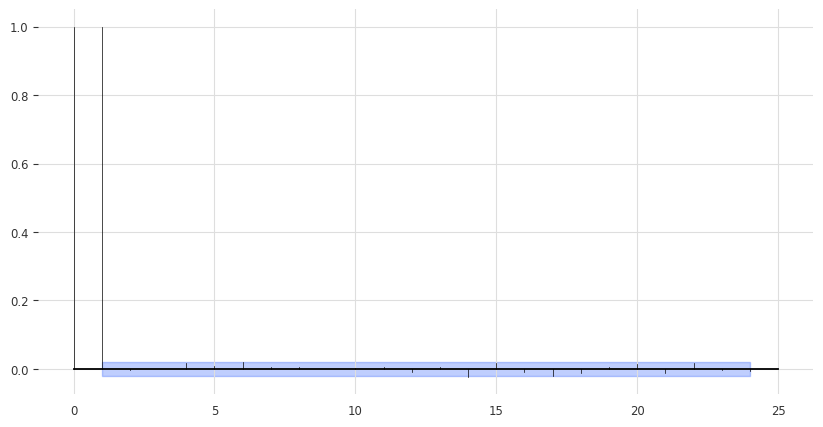

In [14]:
plot_pacf(SP_ENT['cierre'])


En dicha gráfica se muestra una correlación significativa en el primer desfase, seguidas de correlaciones que no son significativas. Esto nos sugiere que, en el caso de utilizar el modelo ARIMA, deberíamos ajustar el parámetro autoregresivo $p$ a $2$. Podremos utilizar el hecho de que los datos diferenciados poseen una correlación significativa de $1$ LAG para ajustar más adelante los parámetros del modelo.

## 3 Modelo de Pronóstico.

Debido al análisis realizado en la sección anterior, se probaron distintos modelos de pronóstico pertenecientes a *Darts*. Entre ellos, se encuentran los siguientes:

* Modelos que podríamos llamar "Clásicos", tales como el Modelo Auto-Regresivo de Media Móvil (ARIMA), el Modelo de Suavizado Exponencial, el Modelo Theta ($\theta$), y el Modelo TBATS (Trigonometría Estacional, Transformación Box-Cox, errores ARMA y componentes Estacionales y de Tendencia).

* Modelos de Redes Neuronales, como RNN (Modelo de Redes Neuronales Recurrentes), el Modelo NBEATS (Análisis de expansión de base neuronal para el Pronóstico de series temporales), y NHITS.

Todos estos modelos ajustaron sus parámetros y se aplicaron sobre nuestra serie de tiempo. Sin embargo, aquel que ha demostrado la mejor aproximación a los valores de prueba, con parámetros ajustados, fue el modelo de regresión basado en XGBoost (Refuerzo de Gradientes Extremo).

Una posible excepción es el modelo RNN a Bloques, que obtuvo un MAPE (Error Porcentual Absoluto Medio) de $6.83$. Sin embargo, esto se debe más a que sigue una tendencia de crecimiento lineal que no se corresponde con las fluctuaciones propias de nuestra serie. Por lo tanto, aplicamos el modelo de regresión XGBoost, que es mucho más eficiente en términos de tiempo y capacidad computacional.

In [15]:
#Empecemos por utilizar la información de LAGS de la gráfica ACF para los parámetros del modelo:
modelo_xgb = XGBModel(
    lags=1,
    output_chunk_length=80,
    random_state=42,
    multi_models=True,
    use_static_covariates=False
)

In [16]:
#Ajustemos el modelo a nuestros datos:
modelo_xgb.fit(SP_ENT)

XGBModel(lags=1, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=80, add_encoders=None, likelihood=None, quantiles=None, random_state=42, multi_models=True, use_static_covariates=False)

Para determinar el error en todas las pruebas de modelos que se realizaron utlilizamos el Error de Porcentaje Medio Absoluto (MAPE), entre los pronosticos y los datos de validación como sigue:

In [17]:
#Realicemos el pronóstico de los casi 3 meses:
prediccion_xgb = modelo_xgb.predict(len(SP_VAL), verbose=True, show_warnings=True)
#Determinemos su MAPE:
print("El MAPE del modelo de Regresión XGBoost es: {:.2f}".format(mape(SP_VAL, prediccion_xgb)))

El MAPE del modelo de Regresión XGBoost es: 8.06


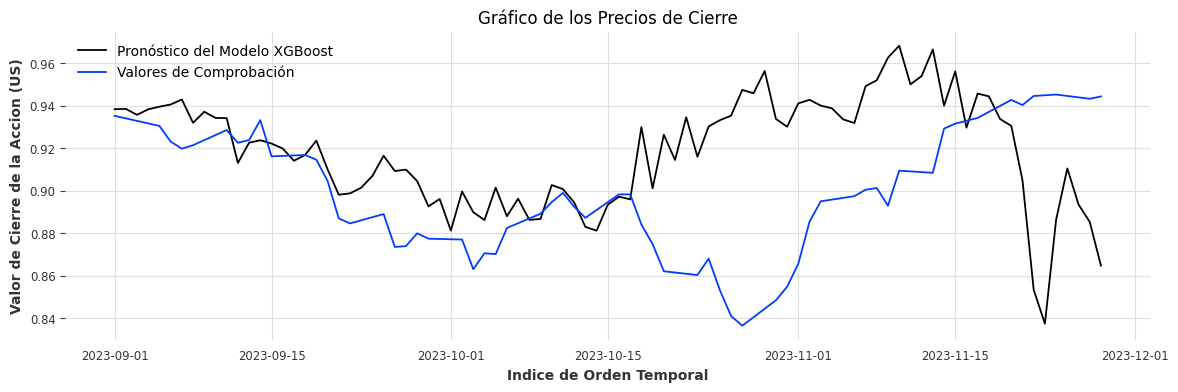

In [18]:
#Comparemos gráficamente los prónosticos de la Regresión con los valores de Prueba:
XGB_GRA = prediccion_xgb.pd_dataframe()

plt.figure(figsize=(14,4))

plt.plot(XGB_GRA.index, XGB_GRA['cierre'], label='Pronóstico del Modelo XGBoost')
plt.plot(SP_VAL_GRA.index, SP_VAL_GRA['cierre'], label='Valores de Comprobación')

plt.xlabel('Indice de Orden Temporal')
plt.ylabel('Valor de Cierre de la Accion (US)')

plt.title('Gráfico de los Precios de Cierre')
plt.legend()
plt.grid(True)
plt.show()

La regresión XGBoost no acepta ningún tipo de **Covariables** ni estacionarias, pasadas o futuras, lo cual es una clara desvenja con respecto a otros métodos tales como el RNN o N-BEATS. Existen varios datos que podriamos haber utilizado como **Covariables pasadas**, especialmente el dato de la liquidez de la Reserva Federal Estadounidence (FED) que esta estrechamente relacionado con las bolsas de las que se obtiene este ínice. Sin embargo, nosotros estamos límitados y no tenemos acceso a ese tipo de datos.

### 3.2 Backtesting
El backtesting simula predicciones que históricamente se habrían obtenido con un modelo dado. Dichos pronósticos simulados siempre se definen con respecto a un *horizonte de pronóstico*, que es el número de pasos de tiempo que separan el tiempo de predicción del tiempo de pronóstico.

En este caso se fueron realizando pronósticos en *horizontes*/periodos de $3$ días con una versión optimizada del Backtesting, esta requiere menos tiempo y coste computacional a cambio de no reentrenar los datos (`retrain=0`).

In [19]:
#Utilicemos el método para en Backtesting:
pronosticos_historicos = modelo_xgb.historical_forecasts(SP_ENT, start=pd.Timestamp('20220101'), retrain=0, forecast_horizon=3, verbose=True, show_warnings=True, enable_optimization=True)

In [20]:
#Veamos que tanto error posee:
print("El MAPE entre los datos de entrenamiento y el pronóstico historico es: {:.2f}".format(mape(SP_ENT, pronosticos_historicos)))

El MAPE entre los datos de entrenamiento y el pronóstico historico es: 3.98


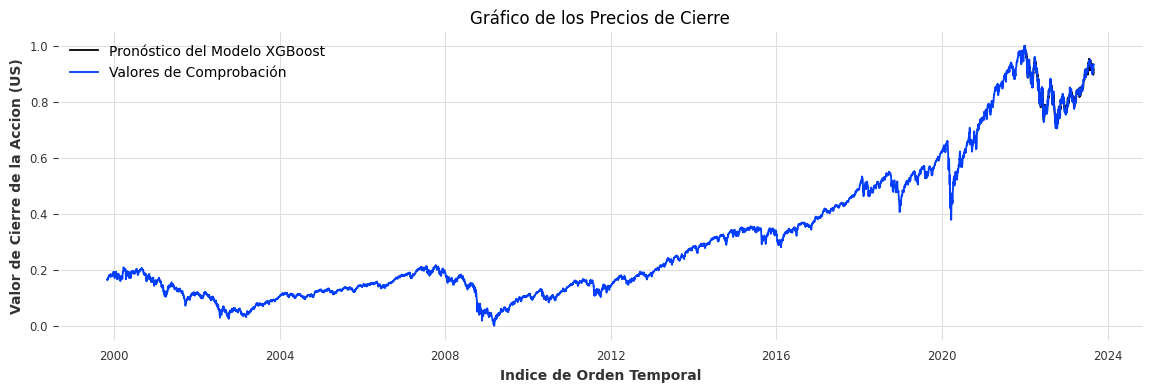

In [21]:
#Comparemoslo graficamente con los valores de la serie:
HIS_GRA = pronosticos_historicos.pd_dataframe()

plt.figure(figsize=(14,4))

plt.plot(HIS_GRA.index, HIS_GRA['cierre'], label='Pronóstico del Modelo XGBoost')
plt.plot(SP_ENT_GRA.index, SP_ENT_GRA['cierre'], label='Valores de Comprobación')

plt.xlabel('Indice de Orden Temporal')
plt.ylabel('Valor de Cierre de la Accion (US)')

plt.title('Gráfico de los Precios de Cierre')
plt.legend()
plt.grid(True)
plt.show()

Como se  puede apreciar el valor de los pronósticos concuerda, en un margen aceptable con los datos historicos del S&P $500$.

### 3.3 Pruebas de Residuos.
Las pruebas de residuos se utilizan para evaluar la calidad de un modelo de pronóstico para una serie de tiempo. Los residuos son las diferencias entre los valores observados y los valores pronosticados por el modelo.

Dentro del modulo *Darts* para hallar los residuos de una serie con respecto a nuestra Serie de Tiempo deberemos utilizar el modelo de pronóstico que deseemos probar y entrenarlo con datos univariados.

In [22]:
#Obtengamos los residuos de este modelo aplicado a la serie de tiempo:
modelo_xgb_res = XGBModel(lags=1,output_chunk_length=80,random_state=42,multi_models=True,use_static_covariates=False)
modelo_xgb_res.fit(PTS_SP['cierre'])

residuos = modelo_xgb_res.residuals(PTS_SP['cierre'], forecast_horizon=3, retrain=False)

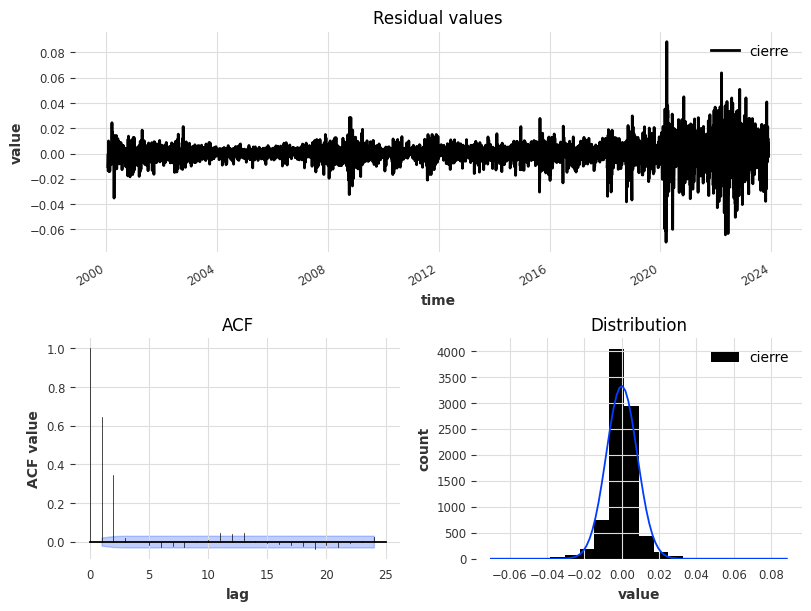

In [23]:
# Realicemos las gráficas que resuman la información que podemos obtener de dichos residuos:
plot_residuals_analysis(residuos)

Como se puede observar nuestra distribución esta centrada en $0$ con lo cual nuestro modelo *XGBoost* no esta sesgado. Apesar de ello, la gráfica **ACF** muestra un desface significativo en los primeros **LAGS**, por lo que dicho modelo esta perdiendo información principalmente de los datos anteriores al año $2004$. Sin embargo, dichos datos no creemos sean tan significativos al momento de influir en los pronósticos de nuestro modelo.  

Nos interesa saber si la regresión basada en el XGBoost es capaz de capturar las **Tendencias** de la serie de tiempo, para ello realizaremos una **Prueba de Raíz Unitaria**, esto se hace mediante la prueba de **Dickey-Fuller Aumentada** como sigue:

In [24]:
# Utilicemos Darts para realizar la prueba:
stat_res = stationarity_test_adf(PTS_SP['cierre'], maxlag=24)

# Procesemos los datos de la prueba (para poder leerlos bien):
prueba_raiz =  pd.DataFrame(
    {"Valores":[stat_res[0],stat_res[1],stat_res[2],stat_res[3],stat_res[4]['1%'],stat_res[4]['5%'],stat_res[4]['10%'],stat_res[5]],
     "Métrica":['ADF', 'p-valor', 'LAGS usados', 'No. Observaciones usadas', 'Valor Critico(1%)', 'Valor Critico(5%)','Valor Critico(10%)','Auto-LAG no nulo']})

# Veamos los resultados de la prueba:
prueba_raiz

,Valores,Métrica
0,0.929806,ADF
1,0.993467,p-valor
2,21.000000,LAGS usados
3,8772.000000,No. Observaciones usadas
4,-3.431096,Valor Critico(1%)
5,-2.861870,Valor Critico(5%)
6,-2.566945,Valor Critico(10%)
7,-69265.770480,Auto-LAG no nulo


El *P-Valor* de esta prueba indica que tan probable es que los residuos de nuestra serie de tiempo tengan una raíz unitaria (Esta es nuestra Hipótesis Nula **H$0$**), entre menor sea *P* más probable sera que la serie de tiempo tenga una raiz unitaria y viceberza.

Nuestro *P-Valor* es extremadamente alto, con lo cual es muy probable este modelo de pronóstico SI capture la tendencia de nuestra serie de tiempo.

## Concluciones.

1. Debido a la naturaleza del mercado de acciones, es extremadamente difícil encontrar un modelo de pronóstico para las series temporales de los OHLCV (Open, High, Low, Close, Volume) de acciones de empresas.
2. De acuerdo con lo anterior, debido a la falta de una estacionalidad o tendencia clara en este tipo de series temporales, los modelos clásicos como ARIMA y SARIMA pueden no resultar satisfactorios en sus pronósticos.
3. Nuevos tipos de modelos basados en Redes Neuronales e Inteligencia Artificial pueden resultar más efectivos para este tipo de datos al realizar pronósticos. De los que hemos probado, como los modelos de Redes Neuronales Recurrentes (RNN), el Análisis de expansión de la base neuronal (N-BEATS), etc., el que se ajustó mejor a nuestros datos de validación es el modelo de regresión basado en XGBoost.
4. A pesar de que la regresión XGBoost posee un Error de Porcentaje Medio Absoluto (MAPE) menor al 10%, debido a la naturaleza de los datos, este modelo resulta ineficaz para predecir cambios de valor en las acciones del S&P 500 en plazos relativamente largos de tiempo, notese la divergencia entre los pronósticos del modelo y los datos de validación a partir del $15$ de Septiembre de $2023$.
5. El modelo de pronóstico que utilizamos para estos datos, en cambio, resulta útil para prever en un grado aceptable las tendencias de dichas series temporales, como lo evidencian el Backtesting y las Pruebas de residuos. Esto es válido siempre y cuando se consideren datos exógenos importantes, como la liquidez de la FED, eventos geopolíticos o desastres naturales.  